In [1]:
import os
import sys
sys.path.append('../')

from collections import Counter

import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import umap
import numpy as np
# from PIL import Image
# from torchvision.transforms import ToTensor
from tqdm import tqdm

from utils.main import read_py, get_device
from utils.data import get_loaders, get_default_transforms

c:\Users\Andrii\miniconda3\envs\image_retrieval\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
SUBMISSION_FILE = '../submissions/arcface_consistency_reg_vit_clip_lora_1_0_0_hardmargin_s30_m0.15_lr3e-4_backbone3e-6_freezeb16_lambda300.csv'
assert os.path.exists(SUBMISSION_FILE)

MODEL_CONFIG_PATH = '../train_configs/arcface_consistency_reg_vit_clip_lora.py'
assert os.path.exists(MODEL_CONFIG_PATH)

MODEL_CHECKPOINT_PATH = '../checkpoints/arcface_consistency_reg_vitclip_2_0_lora_bs8_100epochs_cosinelr_lr3e-4_backbonelr3e-6_unfreezeafter16_hardmargin_s30_m0.15_lambda300/epoch=34-step=14945.ckpt'
assert os.path.exists(MODEL_CHECKPOINT_PATH)

TRAIN_FILE = '../data/train.csv'
TRAIN_DIR = '../data/train/'
TEST_DIR = '../data/test/'
DEVICE = get_device()

In [36]:
sub_df = pd.read_csv(SUBMISSION_FILE)
train_df = pd.read_csv(TRAIN_FILE)

In [37]:
all_classes = list(sub_df['class'].apply(lambda x: x.split(' ')).values)

In [38]:
all_classes = [item for sublist in all_classes for item in sublist]

In [39]:
classes_counts = Counter(all_classes)

In [40]:
top_classes = classes_counts.most_common(20)

In [41]:
ranking = {pair[0]: rank 
           for rank, pair in enumerate(classes_counts.most_common())}

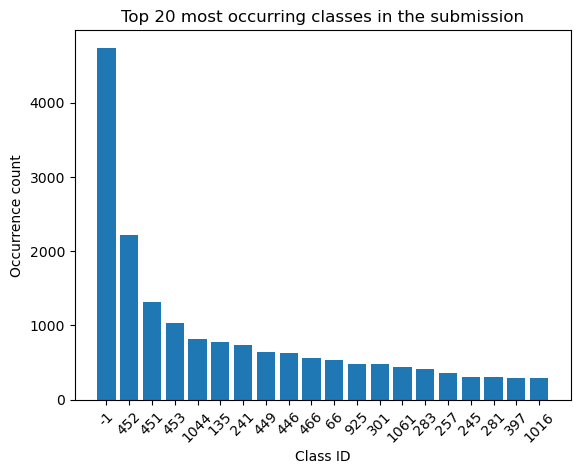

In [42]:
plt.bar([counts[0] for counts in top_classes], [counts[1] for counts in top_classes])
plt.title('Top 20 most occurring classes in the submission')
plt.xlabel('Class ID')
plt.ylabel('Occurrence count')
plt.xticks(rotation=45)
plt.show()

In [43]:
classes_samples = train_df.groupby('class').sample(1).reset_index()
top_classes_samples = classes_samples[classes_samples['class'].isin([int(counts[0]) for counts in top_classes])].copy()
top_classes_samples['class_count'] = top_classes_samples['class'].apply(lambda x: classes_counts[str(x)])

In [44]:
top_classes_samples = top_classes_samples.sort_values('class_count', ascending=False)

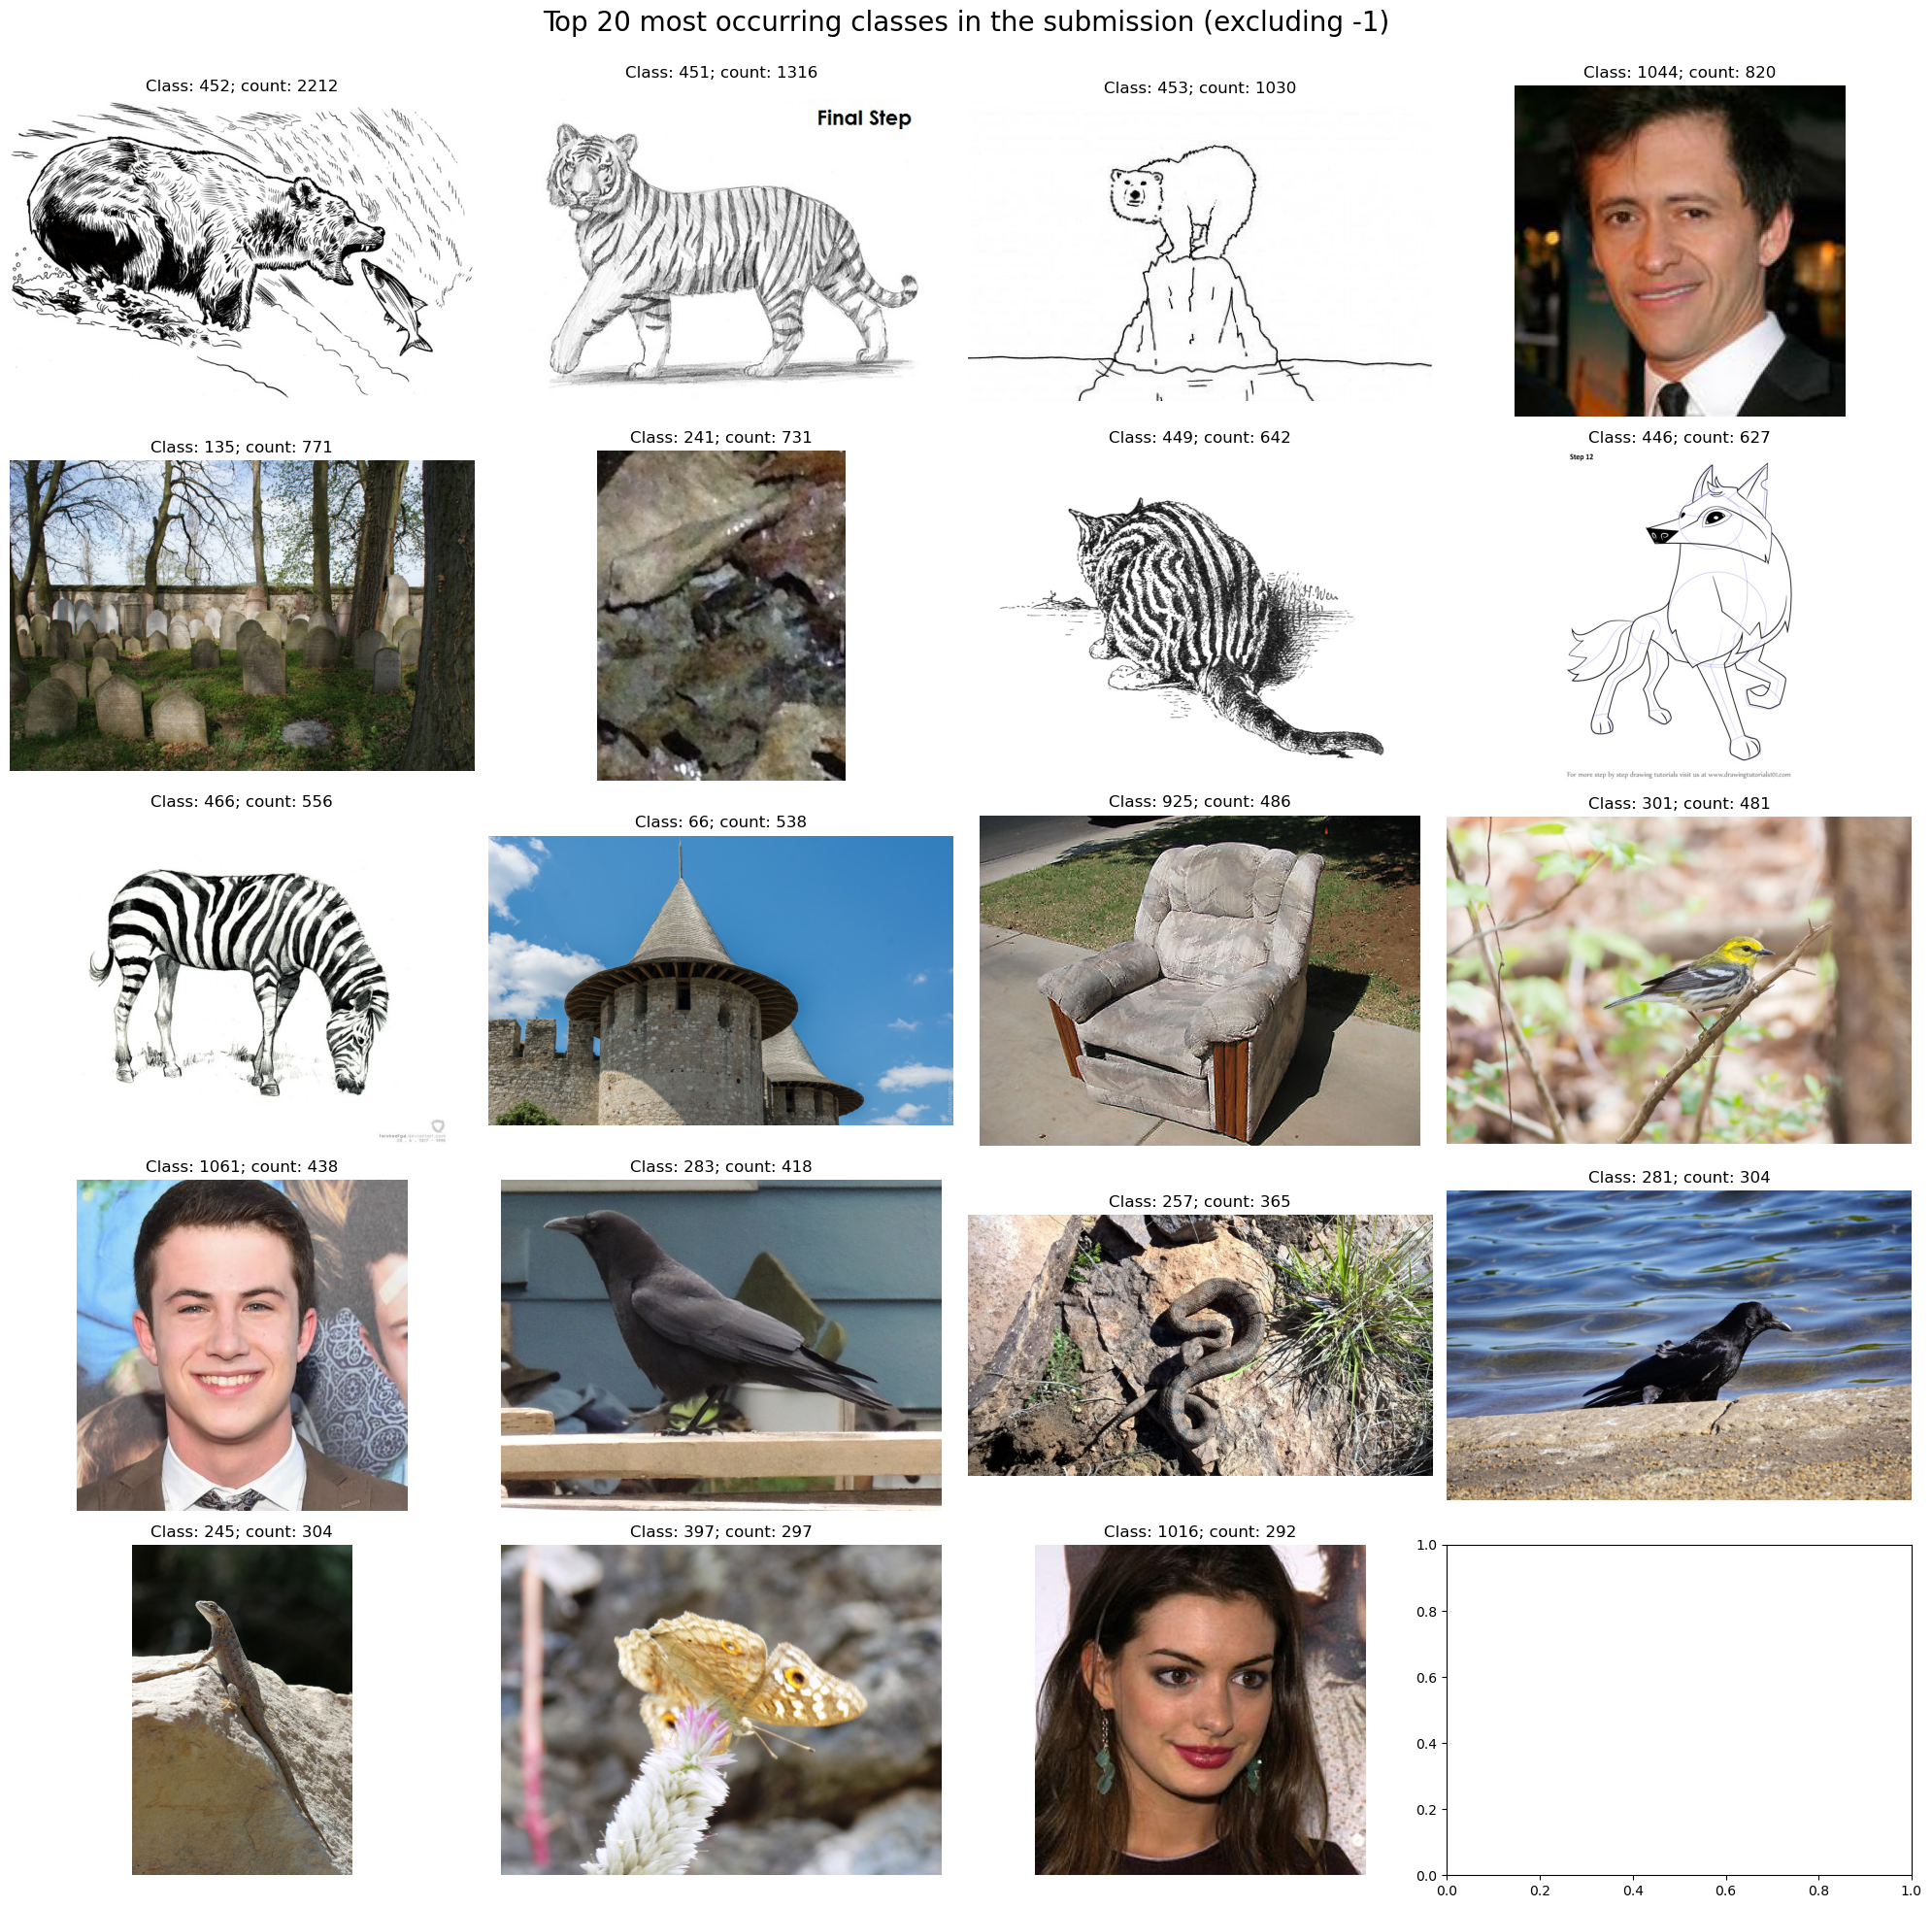

In [45]:
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
for i, (_, row) in enumerate(top_classes_samples.iterrows()):
    row_num = i//4
    col_num = i%4

    img = plt.imread(os.path.join(TRAIN_DIR, f"{row['file_id']}.jpg"))
    axs[row_num, col_num].imshow(img)
    axs[row_num, col_num].set_title(f'Class: {row["class"]}; count: {row["class_count"]}')
    axs[row_num, col_num].axis('off')

plt.suptitle('Top 20 most occurring classes in the submission (excluding -1)', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [46]:
sub_df['class_list'] = sub_df['class'].apply(lambda x: x.split(' '))
sub_df['class_ranks_sum'] = sub_df['class_list'].apply(lambda x: sum([ranking[y] for y in x]))

In [47]:
submission_df_mostcommmon = sub_df.sort_values('class_ranks_sum', ascending=True)

In [48]:
submission_df_mostcommmon = submission_df_mostcommmon.iloc[:10]

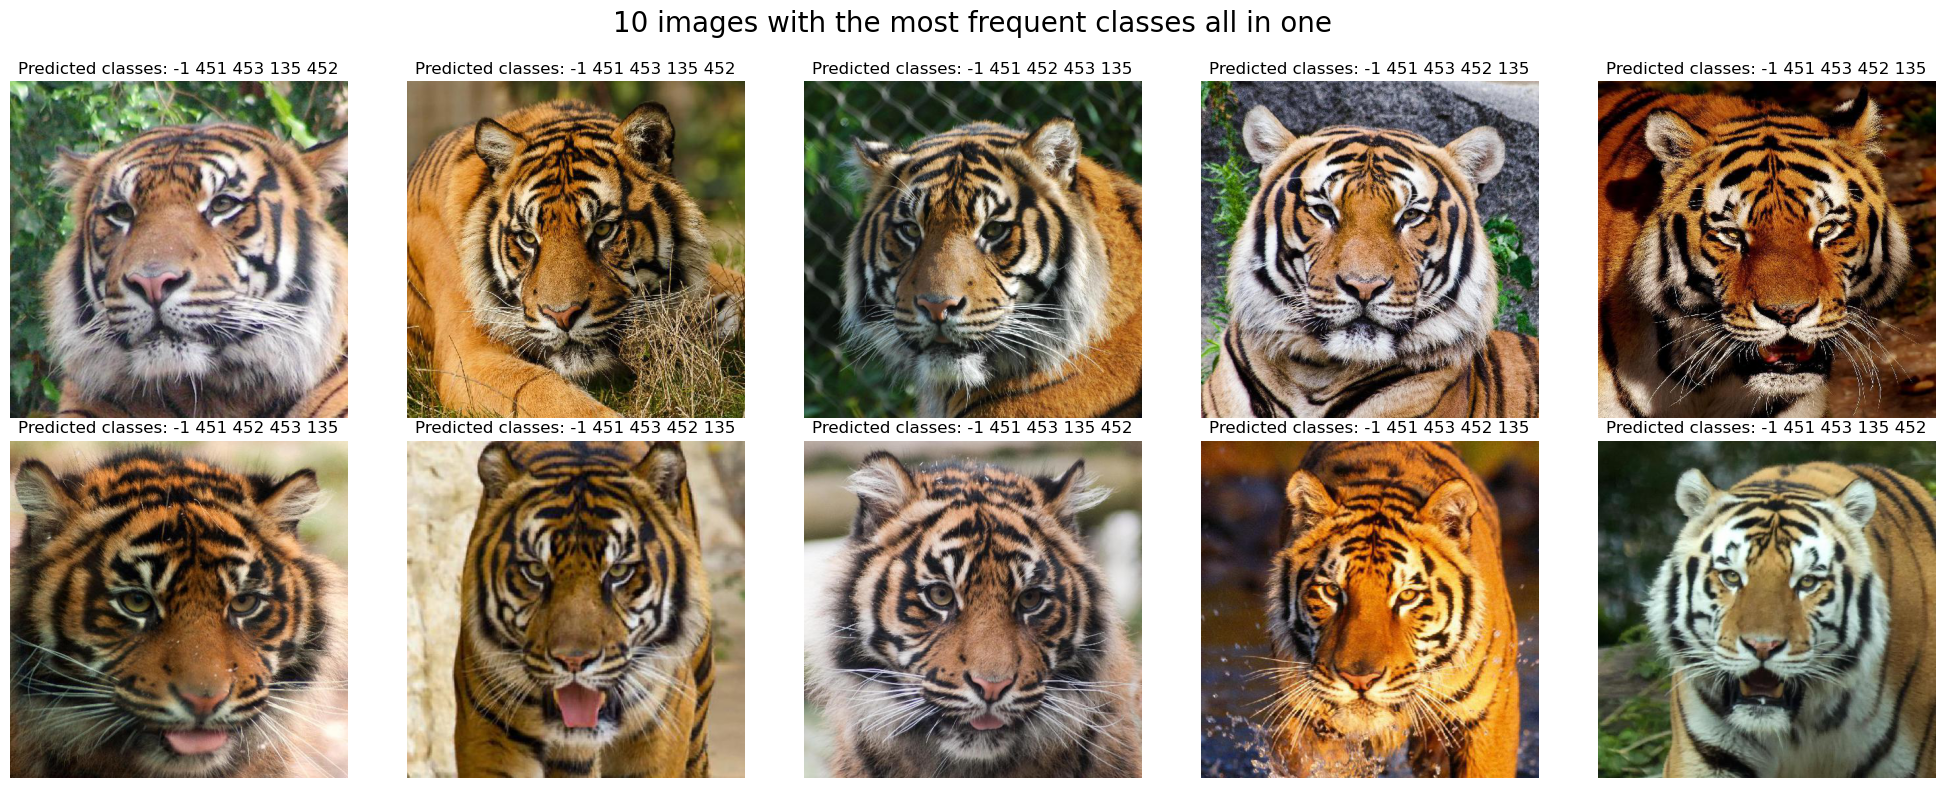

In [49]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, (_, row) in enumerate(submission_df_mostcommmon.iterrows()):
    row_num = i//5
    col_num = i%5

    img = plt.imread(os.path.join(TEST_DIR, f"{row['file_id']}.jpg"))
    axs[row_num, col_num].imshow(img)
    axs[row_num, col_num].set_title(f'Predicted classes: {row["class"]}')
    axs[row_num, col_num].axis('off')

plt.suptitle('10 images with the most frequent classes all in one', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [53]:
CONFIG = read_py(MODEL_CONFIG_PATH).CONFIG

In [51]:
model = CONFIG['model'](**CONFIG['model_params'])
forward = CONFIG['forward'](model, **CONFIG['forward_params'])
forward.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH)['state_dict'])
forward.to(DEVICE)

C:\Users\Andrii\AppData\Local\Temp\ipykernel_22804\670753934.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forward.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH)['s

ConsistencyRegularizationForward(
  (model): ArcfaceOnlyModelLORA(
    (backbone): PeftModel(
      (base_model): LoraModel(
        (model): FeatureGetterNet(
          (model): VisionTransformer(
            (patch_embed): PatchEmbed(
              (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
              (norm): Identity()
            )
            (pos_drop): Dropout(p=0.0, inplace=False)
            (patch_drop): Identity()
            (norm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (blocks): Sequential(
              (0): Block(
                (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
                (attn): Attention(
                  (qkv): Linear(in_features=1280, out_features=3840, bias=True)
                  (q_norm): Identity()
                  (k_norm): Identity()
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=1280, out_features

In [54]:
loaders_config = CONFIG['loaders']
loaders_config.pop('train_transforms', None)
loaders_config.pop('test_transforms', None)
loaders_config.pop('semisupervised', None)
loaders_config.pop('train_on_test_too', None)
loaders_config.pop('train_drop_last', None)
train_loader, val_loader, test_loader = get_loaders(**loaders_config,
                                                    train_transforms=get_default_transforms('test'),
                                                    test_transforms=get_default_transforms('test'))

In [20]:
# def obtain_embedding(img_path):
#     img = Image.open(img_path).convert('RGB').resize((224, 224))
#     img = ToTensor()(img).unsqueeze(0).to(DEVICE)

#     return forward(img, return_embedding=True).cpu().detach().numpy()[0]

# train_df['embedding'] = train_df['file_id'].apply(lambda x: obtain_embedding(os.path.join(TRAIN_DIR, f"{x}.jpg")))

In [55]:
train_emb_df_elems = []
for img, label in tqdm(train_loader):
    img = img.to(DEVICE)
    with torch.no_grad():
        embeddings = forward(img, return_embedding=True).cpu().detach().numpy()

    for emb, lab, im in zip(embeddings, label, img.cpu().numpy()):
        train_emb_df_elems.append({'class': lab.item(), 'embedding': emb, 'image': im})

train_emb_df = pd.DataFrame(train_emb_df_elems)

100%|█████████▉| 427/428 [04:29<00:00,  1.58it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Andrii\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Andrii\AppData\Local\Temp\ipykernel_22804\4080863243.py", line 5, in <module>
    embeddings = forward(img, return_embedding=True).cpu().detach().numpy()
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Andrii\miniconda3\envs\image_retrieval\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Andrii\miniconda3\envs\image_retrieval\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Andrii\Data\_UNIVER\UCU\3 sem\CV\image_retrieval\notebooks\..\forwards\consistency_reg_forward.py", line 34

In [56]:
train_emb_df = pd.DataFrame(train_emb_df_elems)

In [57]:
reducer = umap.UMAP()

In [59]:
final_embeddigs = reducer.fit_transform(np.stack(train_emb_df['embedding'].values))

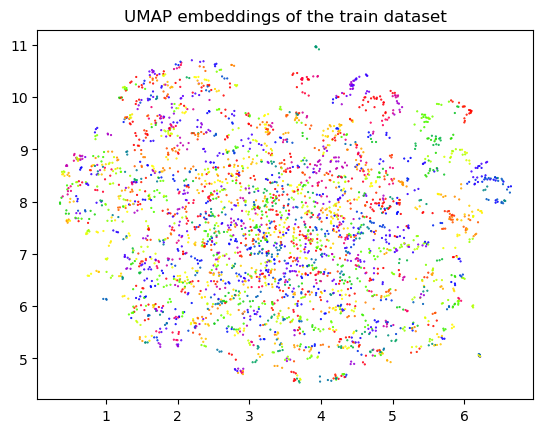

In [60]:
plt.scatter(final_embeddigs[:, 0], final_embeddigs[:, 1], c=train_emb_df['class'], s=0.3, cmap='prism')
plt.title('UMAP embeddings of the train dataset')
plt.show()

In [61]:
random_classes = np.random.choice(train_emb_df['class'].unique(), 20)

In [62]:
train_emb_df['viz_embeddings'] = final_embeddigs.tolist()

In [63]:
random_classes_samples = train_emb_df[train_emb_df['class'].isin(random_classes)].copy()

In [64]:
random_classes_samples.head(5)

class                                          embedding  \
49     155  [0.4896651, 0.0, 0.0, 1.4758036, 0.0, 0.0, 0.0...   
284    656  [1.3971425, 0.15522186, 0.33733487, 0.0, 0.091...   
337    234  [0.053856034, 0.15986937, 0.0, 0.3108305, 0.0,...   
504    990  [0.8221491, 0.0, 0.0, 0.0, 0.0, 0.44840083, 0....   
529    656  [1.0483865, 0.0, 0.055232078, 0.553073, 0.1934...   

                                                 image  \
49   [[[0.27058825, 0.27450982, 0.2784314, 0.278431...   
284  [[[0.015686275, 0.019607844, 0.015686275, 0.01...   
337  [[[0.5137255, 0.6392157, 0.60784316, 0.5411765...   
504  [[[0.8784314, 0.88235295, 0.8862745, 0.8901961...   
529  [[[0.6745098, 0.6627451, 0.654902, 0.654902, 0...   

                               viz_embeddings  
49      [3.60856556892395, 5.744532108306885]  
284  [3.5585856437683105, 6.5116777420043945]  
337   [4.8914875984191895, 7.838357925415039]  
504    [3.143552780151367, 7.045743465423584]  
529    [3.531139612197876, 6.465349197387695]

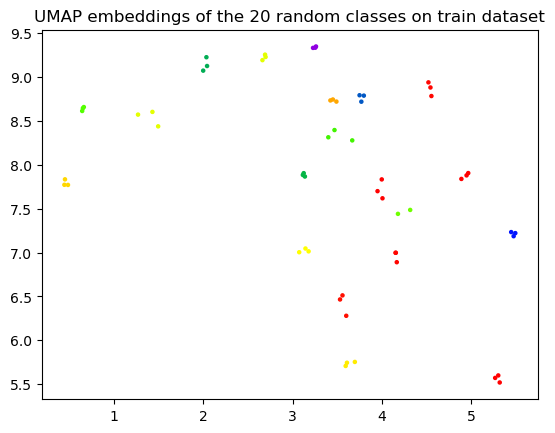

In [65]:
plt.scatter(random_classes_samples['viz_embeddings'].apply(lambda x: x[0]), 
            random_classes_samples['viz_embeddings'].apply(lambda x: x[1]), 
            c=random_classes_samples['class'], 
            s=5, cmap='prism')
plt.title('UMAP embeddings of the 20 random classes on train dataset')
plt.show()

In [66]:
# sub_df['embedding'] = sub_df['file_id'].apply(lambda x: obtain_embedding(os.path.join(TEST_DIR, f"{x}.jpg")))

In [67]:
test_emb_df_elems = []
for img in tqdm(test_loader):
    img = img.to(DEVICE)
    with torch.no_grad():
        embeddings = forward(img, return_embedding=True).cpu().detach().numpy()

    for emb, lab, im in zip(embeddings, label, img.cpu().numpy()):
        test_emb_df_elems.append({'class': '-1', 'embedding': emb, 'image': im})

test_emb_df = pd.DataFrame(test_emb_df_elems)

100%|██████████| 1640/1640 [15:34<00:00,  1.76it/s]


In [68]:
final_embeddigs_test = reducer.transform(np.stack(test_emb_df['embedding'].values))

In [69]:
test_emb_df['viz_embeddings'] = final_embeddigs_test.tolist()

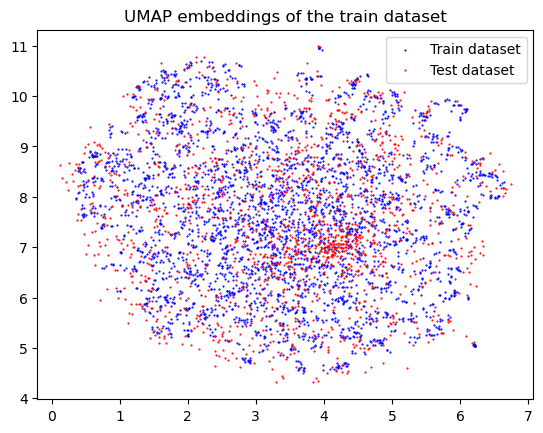

In [70]:
plt.scatter(final_embeddigs[:, 0], final_embeddigs[:, 1], s=0.3, label='Train dataset', c='blue')
plt.scatter(final_embeddigs_test[:, 0], final_embeddigs_test[:, 1], s=0.3, label='Test dataset', c='red')
plt.legend()
plt.title('UMAP embeddings of the train dataset')
plt.show()